# Redes Neurais Recorrentes

As Redes Neurais Recorrentes (RNNs) representam uma classe de redes neurais artificiais especializadas no processamento de dados sequenciais $x^{(1)}, x^{(2)}, \dots, x^{(T)}$. Diferentemente das redes *feedforward* tradicionais, as RNNs possuem conexões cíclicas que permitem a persistência de informações através de um estado oculto (*hidden state*), denotado por $h_t$. Este mecanismo confere à rede uma "memória" de curto prazo, essencial para tarefas onde o contexto temporal é crítico, como processamento de linguagem natural, análise de séries temporais e reconhecimento de fala.

Neste notebook, exploraremos a implementação de uma RNN fundamental (Elman RNN) utilizando PyTorch. Abordaremos desde a geração de um conjunto de dados sintético para classificação de séries temporais, passando pela estruturação correta dos dados em tensores, até a definição da arquitetura e o ciclo de treinamento. O objetivo é classificar sequências temporais ruidosas baseando-se em suas frequências fundamentais.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [16]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Geração de Dados Sintéticos

Para avaliar a capacidade da rede em discernir padrões temporais distintos, construiremos um dataset de classificação multiclasse. O problema consiste em categorizar séries temporais ruidosas com base em suas características espectrais predominantes.

Definimos um conjunto de classes $C$, onde cada classe $c \in \{0, \dots, K-1\}$ está associada a uma frequência fundamental específica $\omega_c$. O sinal observado $x_t$ para uma instância da classe $c$ é modelado como uma função senoidal corrompida por ruído gaussiano:

$$x_t^{(c)} = \sin(\omega_c t) + \epsilon_t, \quad \text{onde } \epsilon_t \sim \mathcal{N}(0, \sigma^2)$$

Esta formulação exige que o modelo aprenda a mapear a sequência de observações ruidosas para a frequência subjacente correta, ignorando a variabilidade estocástica introduzida por $\epsilon_t$.

In [17]:
def generate_synthetic_data(n_samples, seq_len, frequencies):
    """
    Gera dataset sintético para classificação multiclasse de séries temporais.
    
    Args:
        n_samples (int): Número total de amostras.
        seq_len (int): Comprimento de cada série temporal.
        frequencies (list): Lista de frequências, onde o índice é a classe.
    
    Returns:
        data (np.array): Dados gerados (N, Seq_Len, 1).
        labels (np.array): Rótulos das classes (N,).
    """
    time_steps = np.linspace(0, 4 * np.pi, seq_len)
    data = []
    labels = []
    n_classes = len(frequencies)
    
    for _ in range(n_samples):
        # Amostragem uniforme da classe
        label = np.random.randint(0, n_classes)
        
        # Recuperação da frequência correspondente à classe sorteada
        freq = frequencies[label]
        
        # Geração do sinal com ruído
        noise = np.random.normal(0, 0.4, seq_len) # Aumentei levemente o ruído
        sequence = np.sin(freq * time_steps) + noise
        
        data.append(sequence)
        labels.append(label)
        
    data = np.array(data, dtype=np.float32)[..., np.newaxis]
    labels = np.array(labels, dtype=np.longlong)
    
    return data, labels

In [18]:
class_freqs = [0.5, 1.5, 3.0, 5.0] # 4 Classes distintas
raw_data, raw_labels = generate_synthetic_data(n_samples=3000, seq_len=60, frequencies=class_freqs)

print(f"Dataset gerado com {len(class_freqs)} classes. Shape: {raw_data.shape}")

Dataset gerado com 4 classes. Shape: (3000, 60, 1)


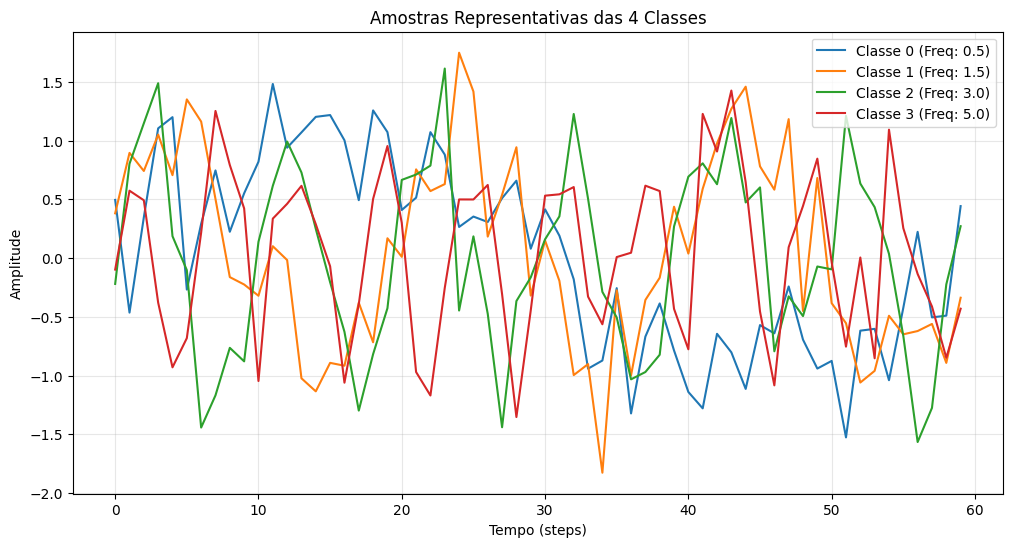

In [19]:
unique_classes = np.unique(raw_labels)
plt.figure(figsize=(12, 6))

for cls in unique_classes:
    idx = np.where(raw_labels == cls)[0][0]
    plt.plot(raw_data[idx], label=f"Classe {cls} (Freq: {class_freqs[cls]})")

plt.title(f"Amostras Representativas das {len(class_freqs)} Classes")
plt.xlabel("Tempo (steps)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [20]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.from_numpy(sequences)
        self.labels = torch.from_numpy(labels)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [21]:
# Divisão treino/teste
train_size = int(0.8 * len(raw_data))
train_data, test_data = raw_data[:train_size], raw_data[train_size:]
train_labels, test_labels = raw_labels[:train_size], raw_labels[train_size:]

# Instanciação dos Datasets
train_dataset = TimeSeriesDataset(train_data, train_labels)
test_dataset = TimeSeriesDataset(test_data, test_labels)

# Configuração dos hiperparâmetros de carregamento
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dimensão do batch de entrada: {next(iter(train_loader))[0].shape}")

Dimensão do batch de entrada: torch.Size([64, 60, 1])


## Implementação da Rede Recorrente

Formalmente, para cada passo de tempo $t$, a RNN computa um novo estado oculto $h_t$ baseado no estado anterior $h_{t-1}$ e na entrada atual $x_t$. A equação de recorrência para uma RNN de Elman com função de ativação tangente hiperbólica é dada por:

$$h_t = \tanh(W_{ih} x_t + b_{ih} + W_{hh} h_{t-1} + b_{hh})$$

Onde:
* $W_{ih}$ são os pesos da entrada para o estado oculto.
* $W_{hh}$ são os pesos do estado oculto para o estado oculto (recorrência).
* $b_{ih}, b_{hh}$ são os termos de viés.

### Implementação de Baixo Nível: A Célula Recorrente

Para compreender a mecânica interna de uma RNN, é instrutivo implementar manualmente a operação que ocorre em um único passo de tempo $t$. A "célula" de uma RNN é responsável por receber a entrada atual $x_t$ e o estado oculto anterior $h_{t-1}$, e computar o novo estado oculto $h_t$.

Na implementação abaixo, utilizamos dois módulos `nn.Linear` distintos para representar as transformações lineares da entrada ($W_{ih}$) e do estado oculto ($W_{hh}$). A função de ativação tangente hiperbólica ($\tanh$) é utilizada para manter os valores do estado oculto no intervalo $[-1, 1]$, mitigando problemas de explosão de gradiente em comparação com funções não limitadas como ReLU, embora não resolva o problema de desvanecimento de gradiente em sequências longas.

In [22]:
class SimpleRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Projeção linear da entrada x_t
        self.input2hidden = nn.Linear(input_size, hidden_size)
        # Projeção linear do estado anterior h_{t-1}
        # O viés é opcional aqui pois já existe um em input2hidden
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size, bias=False)
        self.activation = nn.Tanh()

    def forward(self, x_t, h_prev):
        # Cálculo do novo estado oculto
        # h_t = tanh(W_xh * x_t + W_hh * h_prev + b)
        h_t = self.activation(
            self.input2hidden(x_t) + self.hidden2hidden(h_prev)
        )
        return h_t

# Demonstração de um passo de tempo isolado
batch_size = 5
input_size = 10
hidden_size = 20

cell = SimpleRNNCell(input_size, hidden_size)

# Tensores para t=0
x_t = torch.randn(batch_size, input_size)
h_prev = torch.randn(batch_size, hidden_size)

h_next = cell(x_t, h_prev)

print(f"Entrada (x_t): {x_t.shape}")
print(f"Estado anterior (h_prev): {h_prev.shape}")
print(f"Novo estado (h_next): {h_next.shape}")

Entrada (x_t): torch.Size([5, 10])
Estado anterior (h_prev): torch.Size([5, 20])
Novo estado (h_next): torch.Size([5, 20])


### Processamento Sequencial e Unrolling

Uma rede neural recorrente nada mais é do que a aplicação repetida da célula definida anteriormente sobre uma sequência de dados. Este processo é conhecido como *unrolling* (desenrolamento) da rede ao longo do tempo.

A classe `SimpleRNN` abaixo encapsula este comportamento. Ela recebe um tensor de entrada de ordem 3 com dimensões $(N, L, H_{in})$, onde $N$ é o tamanho do lote e $L$ é o comprimento da sequência. O método `forward` itera explicitamente sobre a dimensão temporal, alimentando a saída de um passo como entrada do estado oculto do próximo.

Observe a inicialização do estado oculto $h_0$. É convenção padrão iniciar $h_0$ como um tensor de zeros, o que implica que a rede não possui memória prévia antes do início da sequência, embora existam técnicas para aprender este estado inicial como um parâmetro.

In [23]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = SimpleRNNCell(input_size, hidden_size)

    def forward(self, x_sequence):
        # x_sequence shape: [batch_size, sequence_length, input_size]
        batch_size = x_sequence.size(0)
        seq_len = x_sequence.size(1)
        
        # Inicializa o estado oculto h_0 com zeros
        # Deve estar no mesmo dispositivo (CPU/GPU) que a entrada
        h_t = torch.zeros(batch_size, self.hidden_size).to(x_sequence.device)
        
        # Lista para armazenar o histórico dos estados ocultos
        outputs = []
        
        # Loop temporal (Unrolling)
        for t in range(seq_len):
            # Seleciona a fatia de tempo t: (batch_size, input_size)
            x_t = x_sequence[:, t, :] 
            
            # Atualiza o estado oculto usando a célula
            h_t = self.cell(x_t, h_t)
            
            # Armazena o estado atual
            outputs.append(h_t)
            
        # Empilha a lista de tensores na dimensão temporal (dim=1)
        # Resultado final: [batch_size, sequence_length, hidden_size]
        return torch.stack(outputs, dim=1)

# Demonstração do processamento da sequência completa
seq_length = 7
rnn_from_scratch = SimpleRNN(input_size, hidden_size)

# Tensor simulando uma sequência temporal completa
x_sequence = torch.randn(batch_size, seq_length, input_size)

output_sequence = rnn_from_scratch(x_sequence)

print(f"Sequência de Entrada: {x_sequence.shape}")
print(f"Sequência de Saída (Estados Ocultos): {output_sequence.shape}")

Sequência de Entrada: torch.Size([5, 7, 10])
Sequência de Saída (Estados Ocultos): torch.Size([5, 7, 20])


### O Módulo nn.RNN do PyTorch

Em ambientes de produção e pesquisa utilizamos a classe `torch.nn.RNN`. Esta implementação é altamente otimizada, suportando aceleração via cuDNN (CUDA Deep Neural Network library) e execução paralela onde possível.

Ao instanciar `nn.RNN`, os principais hiperparâmetros são:
* `input_size`: O número de features esperadas na entrada $x_t$.
* `hidden_size`: O número de features no estado oculto $h_t$.
* `num_layers`: Número de camadas recorrentes empilhadas (stacked RNN).
* `batch_first`: Se `True`, a entrada e saída são fornecidas como $(Batch, Seq, Feature)$. O padrão do PyTorch é `False` $(Seq, Batch, Feature)$.
* `nonlinearity`: Pode ser `'tanh'` (padrão) ou `'relu'`.

A chamada `forward` deste módulo espera uma entrada $X$ e um estado oculto inicial $h_0$ (opcional, assume-se zero se omitido).

Para a tarefa de classificação, utilizaremos o vetor do estado oculto do último passo de tempo, $h_T$, como uma representação comprimida de toda a sequência. Este vetor será alimentado em uma camada totalmente conectada (linear) para projetar as pontuações das classes (logits).

In [24]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Camada Recorrente
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Camada Linear para classificação baseada no último estado oculto
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Inicialização do estado oculto (h0)
        # Dimensões: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass na RNN
        # out: contém os estados ocultos de todos os timesteps
        # _ : contém o estado oculto do último timestep (h_n)
        out, _ = self.rnn(x, h0)
        
        # Selecionamos o output do último passo de tempo (many-to-one architecture)
        # out[:, -1, :] pega todas as amostras do batch, último tempo, todas as features ocultas
        out = out[:, -1, :]
        
        # Decodificação para classes
        out = self.fc(out)
        return out

In [25]:
input_dim = 1                       # Univariado
hidden_dim = 32                     # Capacidade de memória da RNN
output_dim = len(class_freqs)       # Número de classes
n_layers = 1                        # Profundidade da recorrência

model = RNNClassifier(input_dim, hidden_dim, output_dim, n_layers).to(device)
print(model)

RNNClassifier(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)


## Treinamento

A otimização dos parâmetros $\theta$ da rede é realizada através da minimização da função de custo Cross-Entropy, adequada para problemas de classificação multiclasse (ou binária quando não se usa sigmoide na saída final).

$$\mathcal{L}(\theta) = -\frac{1}{N} \sum_{i=1}^{N} \log \left( \frac{e^{s_{y_i}}}{\sum_{j} e^{s_j}} \right)$$

Onde $s$ são os *logits* produzidos pela rede e $y_i$ é a classe verdadeira. Utilizaremos o otimizador Adam, que adapta a taxa de aprendizado para cada parâmetro individualmente baseando-se nos momentos de primeira e segunda ordem dos gradientes.

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)
        
        # Forward
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward e Otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Métricas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

Epoch [5/15], Loss: 0.0840, Accuracy: 99.79%
Epoch [10/15], Loss: 0.0182, Accuracy: 100.00%
Epoch [15/15], Loss: 0.0077, Accuracy: 100.00%


## Inferência e Análise de Resultados

Após a convergência do modelo, é crucial avaliar qualitativamente o desempenho da rede em dados não vistos. A visualização abaixo apresenta amostras do conjunto de teste juntamente com a predição do modelo e a probabilidade associada (obtida via função Softmax). Isso permite inspecionar visualmente se a rede está capturando corretamente as características de frequência que definem as classes.

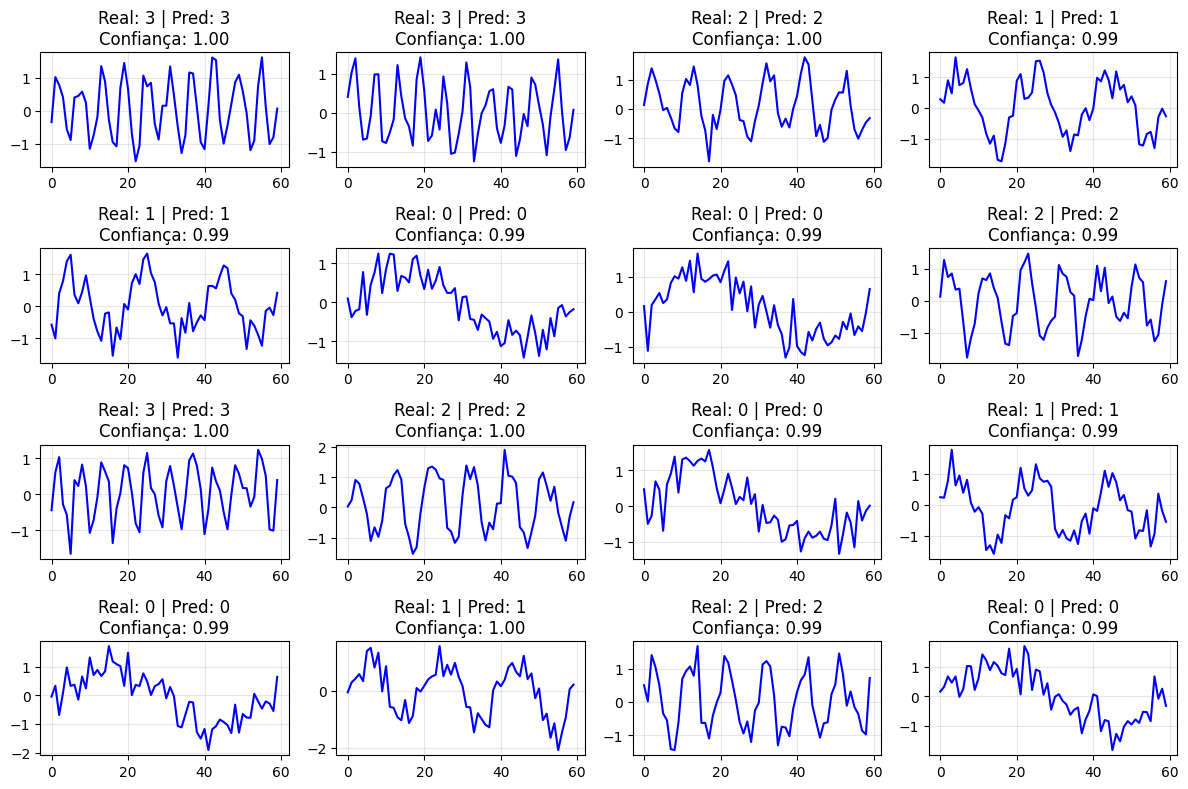

In [28]:
model.eval()
with torch.no_grad():
    # Pegar um batch do conjunto de teste
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    
    # Inferência
    outputs = model(inputs)
    probs = torch.nn.functional.softmax(outputs, dim=1)
    _, preds = torch.max(outputs, 1)
    
    # Plotar resultados
    inputs = inputs.cpu().numpy()
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    probs = probs.cpu().numpy()
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 8))
    axes = axes.flatten()
    
    for i in range(16):
        ax = axes[i]
        ax.plot(inputs[i], color='blue' if preds[i] == labels[i] else 'red')
        ax.set_title(f"Real: {labels[i]} | Pred: {preds[i]}\nConfiança: {probs[i][preds[i]]:.2f}")
        ax.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()